Begun 3/12/24

Comparing full sky healpix sims (with correct coordinate system and remaking the sims each time to avoid constant sample variance bias) to masked healpix sims to see if the distribution of recovered angles is the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    return fit_values

In [4]:
def get_pixels(nside, dec, ra):
    npix = int(nside)**2*12
    allpix = np.arange(npix)
    alldec = hp.pix2ang(nside, allpix)[0]
    allRA = hp.pix2ang(nside, allpix)[1]
    cross0 = 0
    if 0 > np.min(ra) and np.max(ra) > 0:
        print("RA crossing 0")
        cross0 = 1
    dec_lim = np.radians(np.array([dec[0], dec[1]])*(-1.0) + 90.0)
    RA_lim = np.radians(np.array([ra[0], ra[1]]))
    if cross0:
        keep1 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > 0))[0] 
        keep2 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA - 2 * np.pi > RA_lim[0]) & (allRA - 2 * np.pi < 0))[0]
        keep = np.append(np.array(keep1), np.array(keep2))
    else:
        keep = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > RA_lim[0]))[0] 
    return keep


def eq_to_gal(nside, pix):
    lat, lon = hp.pix2ang(nside, pix)
    r = hp.Rotator(coord=['C','G'])
    lat, lon = r(lat, lon)
    temp = hp.ang2pix(nside, lat, lon)
    temp = list(set(temp))
    try:
        assert len(pix) == len(temp)
    except AssertionError:
        print("lost %i pixels out of %i pixels"%(len(pix)-len(temp),len(pix)))
    return temp


def fill_missing_pix(nside, pix, nside_out):
    testmap = np.zeros(nside ** 2 * 12)
    testmap[pix] = 1
    # hp.mollview(testmap)
    # plt.show()
    # exit()
    testmap[testmap == 0] = -0.01
    testmap = hp.smoothing(testmap, sigma = np.radians(0.1), iter = 1)
    testmap[testmap < 0] = 0
    testmap[testmap != 0] = 1
    return hp.ud_grade(testmap, nside_out)

In [5]:
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

6.870972823634812


In [7]:
# Doing 500 sims of full sky maps

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []
output_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.random.normal(0, 5, size=(500))
print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs
print("Injected rotation angles: ")
print(rot_degs)
print("Recovered angles: ")
print(output_angles_only)
print("Percent difference: ")
print(percent_diff)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only)
print("Percent difference: ")
print(percent_diff_eb)

Input angles are: [ -3.84831406   1.56960682   0.62516476  -6.17417919  -4.41365734
  -1.3814877   -0.24288068   9.63144956   2.44924812  -2.81718161
  -0.6858569    5.67911319   7.24306268  -3.6157705   -3.54945574
  -3.37187787  -0.27505177   6.49820683  -0.13257773  -0.16269745
  -6.44059417  -0.45746111  -1.3593082    1.23512021  -1.6723328
   5.06378297   3.04781846   8.13523969  -4.85667774  -3.46225024
   0.78282181   6.34321915  -3.98529116  -2.01377528  -2.83846719
 -11.52048521   5.65945064  -2.74350205   5.80293893  -0.71539125
   0.50041868   0.8295358    3.43192529  -0.43062258   2.29021889
  -2.4161241    2.71431164  -5.31982181   2.97094983   5.63365146
   5.84293603  -4.55366194  -8.47088463  -0.7078465   -3.56621399
   1.22772806  -0.88486323  -3.63073009 -12.07262114  -3.45185311
  -5.95024796  -7.43650759   8.15718844   3.40713656  -1.24853228
   6.13691425   6.4072676    6.19376826   1.21866404 -11.27966306
  -2.3608019    1.80968338   3.62185745   8.52427424  -4.58

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:15:48<00:00, 16.30s/it]

Injected rotation angles: 
[ -3.84831406   1.56960682   0.62516476  -6.17417919  -4.41365734
  -1.3814877   -0.24288068   9.63144956   2.44924812  -2.81718161
  -0.6858569    5.67911319   7.24306268  -3.6157705   -3.54945574
  -3.37187787  -0.27505177   6.49820683  -0.13257773  -0.16269745
  -6.44059417  -0.45746111  -1.3593082    1.23512021  -1.6723328
   5.06378297   3.04781846   8.13523969  -4.85667774  -3.46225024
   0.78282181   6.34321915  -3.98529116  -2.01377528  -2.83846719
 -11.52048521   5.65945064  -2.74350205   5.80293893  -0.71539125
   0.50041868   0.8295358    3.43192529  -0.43062258   2.29021889
  -2.4161241    2.71431164  -5.31982181   2.97094983   5.63365146
   5.84293603  -4.55366194  -8.47088463  -0.7078465   -3.56621399
   1.22772806  -0.88486323  -3.63073009 -12.07262114  -3.45185311
  -5.95024796  -7.43650759   8.15718844   3.40713656  -1.24853228
   6.13691425   6.4072676    6.19376826   1.21866404 -11.27966306
  -2.3608019    1.80968338   3.62185745   8.524274

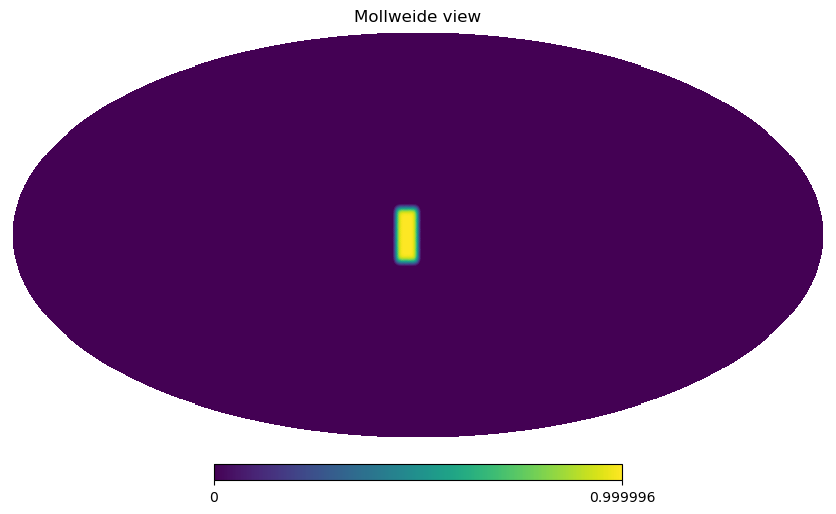

In [8]:
# Example mask
ra = [0,10]
dec = [10,-10]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [10]:
# Now make simulated maps, rotate them, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator
# Difference from before is that I remake the sims each time

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles_mask = []
output_null_eb_angles_mask = []
tt_bias_outputs_mask = []
output_spectra_mask = []

rot_degs_mask = np.random.normal(0, 5, size=(500))
print("Input angles are: " + str(rot_degs_mask))
rotated_maps = []
for rot_deg in tqdm(rot_degs_mask):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra_mask.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs_mask.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles_mask.append(fit_values)
    output_null_eb_angles_mask.append(null_eb_fit_values)
    
rot_degs_mask = np.array(rot_degs_mask)
output_angles_only_mask = np.array(output_angles_mask)[:,0]
output_null_eb_angles_only_mask = np.array(output_null_eb_angles_mask)[:,0]
percent_diff_mask = 100.0*(output_angles_only_mask - rot_degs_mask)/rot_degs_mask
percent_diff_eb_mask = 100.0*(output_null_eb_angles_only_mask - rot_degs_mask)/rot_degs_mask
print("Injected rotation angles: ")
print(rot_degs_mask)
print("Recovered angles: ")
print(output_angles_only_mask)
print("Percent difference: ")
print(percent_diff_mask)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only_mask)
print("Percent difference: ")
print(percent_diff_eb_mask)

Input angles are: [ 4.92368193e+00 -9.30106117e+00 -2.12834465e+00 -1.03111138e+00
  5.62267051e+00  2.33678869e+00 -4.68304750e+00  9.26423312e-01
  1.97341600e-01  5.43905024e-01 -9.35934101e+00 -6.52118843e+00
 -6.16491316e+00 -4.63212305e+00  7.33560321e+00  5.28965986e-01
 -5.64250377e+00  7.82237162e+00 -1.73439452e+00 -1.54691871e+00
  7.30758282e+00  1.35412890e+00  4.71042750e+00 -1.65908672e+00
  6.17245863e-01  4.17629685e-02 -2.59999087e+00  3.95413478e+00
 -8.91291801e-02  5.14993959e+00  4.02656007e-01  1.09448126e+00
  5.77682898e+00  6.00993282e-01 -2.74133560e+00  1.30340673e-01
  1.71592151e+00 -9.19662486e+00  9.77413120e+00  1.65312227e+00
  3.73891664e+00  4.91069456e+00 -4.11474251e+00  9.89303691e+00
 -5.10059736e+00  3.01593446e+00 -4.51538868e+00  5.89129018e+00
 -5.27002093e+00 -4.43785680e+00  1.16038848e+00 -6.38674856e+00
 -4.96074997e+00  5.40804649e+00 -4.92368626e+00 -9.66634435e+00
 -1.18677928e+00 -1.11534450e-01  2.65350110e+00  5.54274928e-01
  3.639

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:12:23<00:00, 15.89s/it]

Injected rotation angles: 
[ 4.92368193e+00 -9.30106117e+00 -2.12834465e+00 -1.03111138e+00
  5.62267051e+00  2.33678869e+00 -4.68304750e+00  9.26423312e-01
  1.97341600e-01  5.43905024e-01 -9.35934101e+00 -6.52118843e+00
 -6.16491316e+00 -4.63212305e+00  7.33560321e+00  5.28965986e-01
 -5.64250377e+00  7.82237162e+00 -1.73439452e+00 -1.54691871e+00
  7.30758282e+00  1.35412890e+00  4.71042750e+00 -1.65908672e+00
  6.17245863e-01  4.17629685e-02 -2.59999087e+00  3.95413478e+00
 -8.91291801e-02  5.14993959e+00  4.02656007e-01  1.09448126e+00
  5.77682898e+00  6.00993282e-01 -2.74133560e+00  1.30340673e-01
  1.71592151e+00 -9.19662486e+00  9.77413120e+00  1.65312227e+00
  3.73891664e+00  4.91069456e+00 -4.11474251e+00  9.89303691e+00
 -5.10059736e+00  3.01593446e+00 -4.51538868e+00  5.89129018e+00
 -5.27002093e+00 -4.43785680e+00  1.16038848e+00 -6.38674856e+00
 -4.96074997e+00  5.40804649e+00 -4.92368626e+00 -9.66634435e+00
 -1.18677928e+00 -1.11534450e-01  2.65350110e+00  5.54274928e-0

In [23]:
def gaussian(x,mean,sigma):
    return 140.0*np.exp(-(x-mean)**2/(2*sigma**2))

Median of full sky percent error: -0.9410745216545315
Std dev of full sky percent error: 0.10838840131201528
Median of masked sky percent error: -0.6404999938702955
Std dev of masked sky percent error: 1.7167994217989218


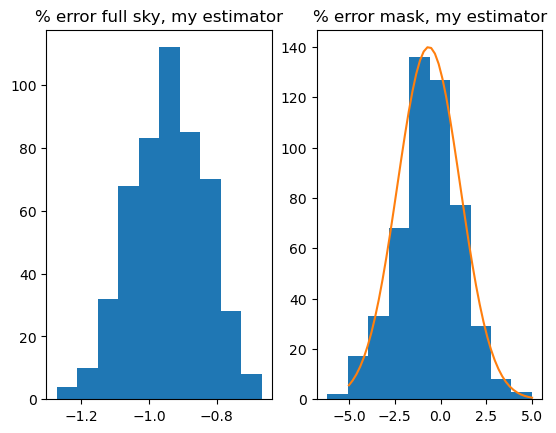

Median of full sky percent error EB estimator: -1.8117350555486982
Std dev of full sky percent error EB estimator: 1.3774866853343486
Median of masked sky percent error EB estimator: -1.747782276592348
Std dev of masked sky percent error EB estimator: 75.463697377647


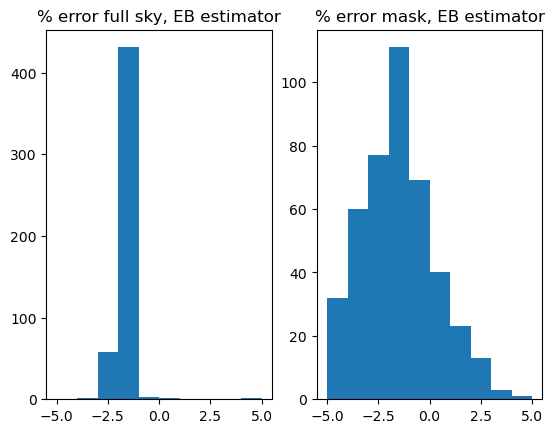

Median of full sky mean TT ratio: 0.9893297623116184
Std dev of full sky mean TT ratio: 0.0011528584266889766
Median of masked sky mean TT ratio: 1.0026616844687761
Std dev of masked sky mean TT ratio: 0.016622281879238084


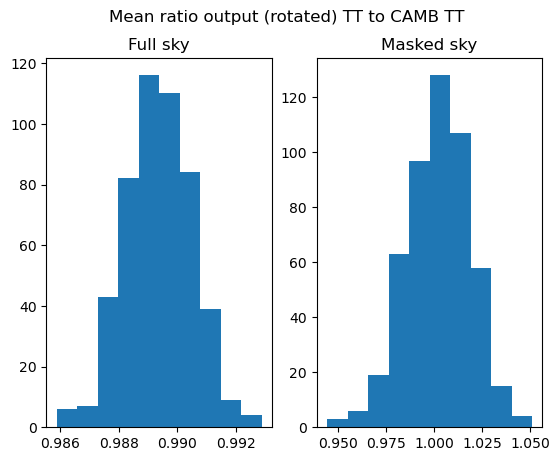

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2)
print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
print("Median of masked sky percent error: " + str(np.median(percent_diff_mask)))
print("Std dev of masked sky percent error: " + str(np.std(percent_diff_mask)))
#ax1.hist(percent_diff, bins=np.arange(21)-10)
ax1.hist(percent_diff)
ax1.set_title("% error full sky, my estimator")
#ax2.hist(percent_diff_mask, bins=np.arange(21)-10)
ax2.hist(percent_diff_mask)
ax2.set_title("% error mask, my estimator")
x = np.linspace(-5,5)
ax2.plot(x,gaussian(x,np.median(percent_diff_mask),np.std(percent_diff_mask)))
plt.show()
plt.close()
fig, (ax1,ax2) = plt.subplots(1,2)
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
print("Median of masked sky percent error EB estimator: " + str(np.median(percent_diff_eb_mask)))
print("Std dev of masked sky percent error EB estimator: " + str(np.std(percent_diff_eb_mask)))
#ax1.hist(percent_diff_eb, bins=np.arange(21)-10)
ax1.hist(percent_diff_eb,range=(-5,5))
ax1.set_title("% error full sky, EB estimator")
#ax2.hist(percent_diff_eb_mask, bins=np.arange(21)-10)
ax2.hist(percent_diff_eb_mask,range=(-5,5))
ax2.set_title("% error mask, EB estimator")
plt.show()
plt.close()
fig, (ax1,ax2) = plt.subplots(1,2)
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
print("Median of masked sky mean TT ratio: " + str(np.median(tt_bias_outputs_mask)))
print("Std dev of masked sky mean TT ratio: " + str(np.std(tt_bias_outputs_mask)))
fig.suptitle("Mean ratio output (rotated) TT to CAMB TT")
ax1.hist(tt_bias_outputs)
ax1.set_title("Full sky")
ax2.hist(tt_bias_outputs_mask)
ax2.set_title("Masked sky")
plt.show()
plt.close()

In [38]:
output_spectra = np.array(output_spectra)
output_spectra_mask = np.array(output_spectra_mask)

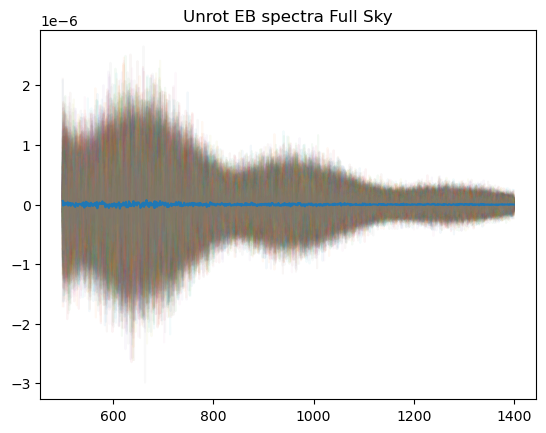

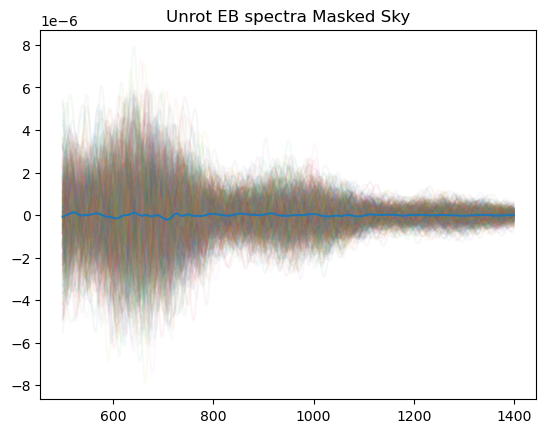

In [39]:
# Plotting all of the EB spectra
mean_EB = np.mean(output_spectra[:,10],axis=0)
mean_EB_mask = np.mean(output_spectra_mask[:,10],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][10],alpha=0.05)
plt.title("Unrot EB spectra Full Sky")
plt.plot(ell_hp,mean_EB)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

for i in range(len(output_spectra_mask)):
    plt.plot(ell_hp,output_spectra_mask[i][10],alpha=0.05)
plt.title("Unrot EB spectra Masked Sky")
plt.plot(ell_hp,mean_EB_mask)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

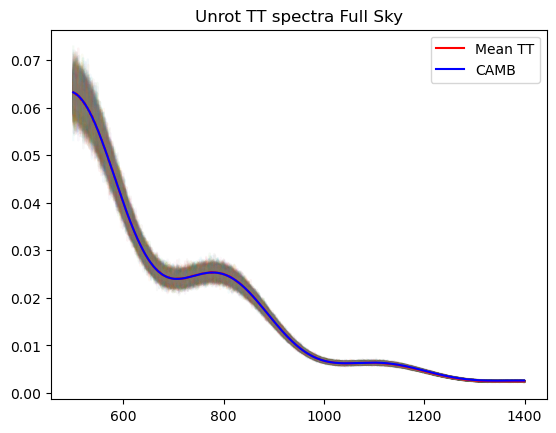

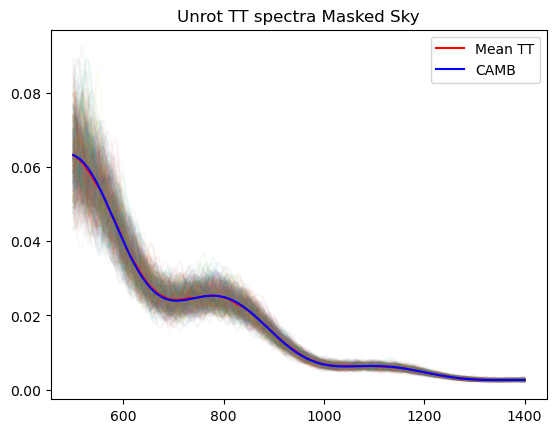

In [44]:
# Plotting all of the TT spectra
mean_TT = np.mean(output_spectra[:,6],axis=0)
mean_TT_mask = np.mean(output_spectra_mask[:,6],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][6],alpha=0.05)
plt.title("Unrot TT spectra Full Sky")
plt.plot(ell_hp,mean_TT,'r',label='Mean TT')
plt.plot(ell[500:1400],ClTT[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra_mask)):
    plt.plot(ell_hp,output_spectra_mask[i][6],alpha=0.05)
plt.title("Unrot TT spectra Masked Sky")
plt.plot(ell_hp,mean_TT_mask,'r',label='Mean TT')
plt.plot(ell[500:1400],ClTT[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

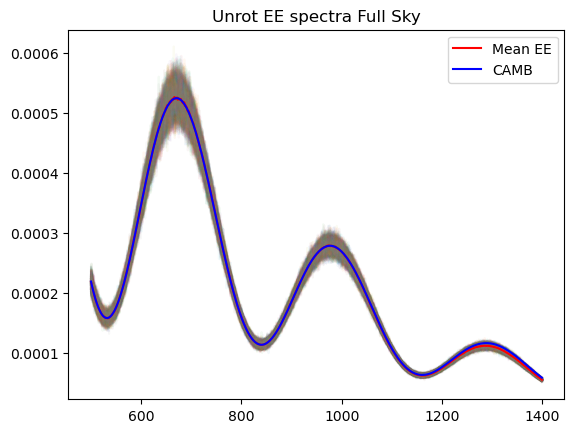

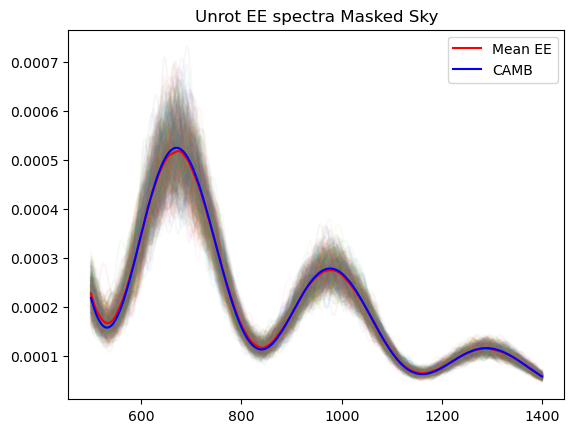

In [42]:
# Plotting all of the EE spectra
mean_EE = np.mean(output_spectra[:,7],axis=0)
mean_EE_mask = np.mean(output_spectra_mask[:,7],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][7],alpha=0.05)
plt.title("Unrot EE spectra Full Sky")
plt.plot(ell_hp,mean_EE,'r',label='Mean EE')
plt.plot(ell[500:1400],ClEE[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra_mask)):
    plt.plot(ell_hp,output_spectra_mask[i][7],alpha=0.05)
plt.title("Unrot EE spectra Masked Sky")
plt.plot(ell_hp,mean_EE_mask,'r',label='Mean EE')
plt.plot(ell[500:1400],ClEE[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

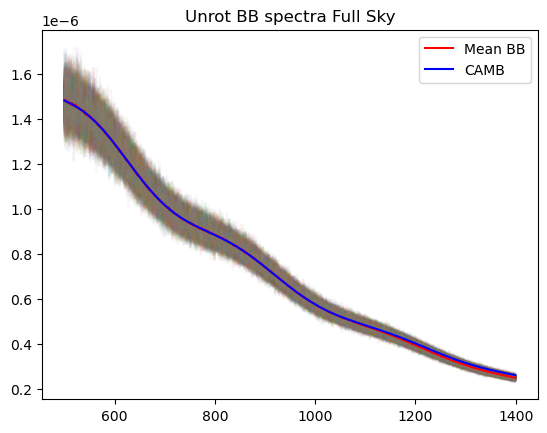

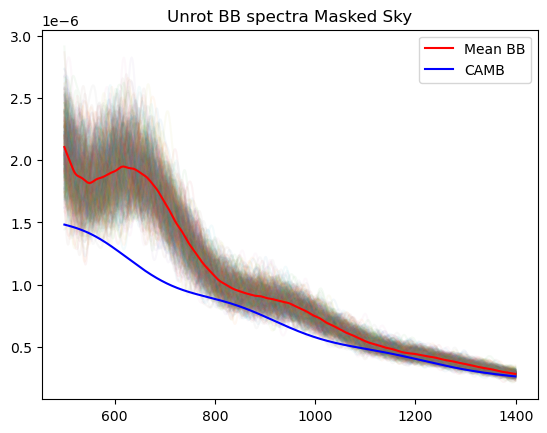

In [43]:
# Plotting all of the BB spectra
mean_BB = np.mean(output_spectra[:,8],axis=0)
mean_BB_mask = np.mean(output_spectra_mask[:,8],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][8],alpha=0.05)
plt.title("Unrot BB spectra Full Sky")
plt.plot(ell_hp,mean_BB,'r',label='Mean BB')
plt.plot(ell[500:1400],ClBB[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra_mask)):
    plt.plot(ell_hp,output_spectra_mask[i][8],alpha=0.05)
plt.title("Unrot BB spectra Masked Sky")
plt.plot(ell_hp,mean_BB_mask,'r',label='Mean BB')
plt.plot(ell[500:1400],ClBB[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

In [45]:
# Anafast should be perfectly accurate up to 1.5*nside and accurate with integration errors that can be reduced
# by more iterations up to 3*nside-1
print(3*nside-1)
print(1.5*nside)

1535
768.0
